In [49]:
import pandas as pd
#from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import re    # 정규식(regular expression) import
from itertools import islice   # enumerate slice 를 위해  
from datetime import datetime
from numpy import NaN, NAN, nan   #NaN 처리를 위해
import glob
import os
import numpy as np
import pickle

In [79]:
stock_dict={} #전역변수 dict선언

In [80]:
def GetFromSE(market):  #서울경제 seoul economy
    url = "https://www.sedaily.com/Stock/Quote?type="
    
    foreign_company=['윙입푸드','헝셩그룹','룽투코리아','골든센츄리'] # 제외할 외국기업 리스트로 선언 ; 

    if market=='P':
        url=url+'1'
    else:
        url=url+'2'
        
    #html=urlopen(url)
    try:
        html=requests.get(url)
        
    except requests.exceptions.RequestException as e:
        print(e)
    else:    
        soup=BeautifulSoup(html.text,"lxml")
      #  soup=BeautifulSoup(html.text,"html.parser")

    all_table=soup.find_all('div',{'class':'table'})

    for thead in all_table:   
        dl=thead.find('dl',{'class':'thead'})
        dt=dl.find('dt')
        fieldName=dt.text  #fieldName 업종 (18개의 thead로 나누어져있다)
    
        if fieldName =='금융':
            continue                  # continue의미는 금융은 건너뛰고 다음 loop 실행
        else:
            tbody=thead.find_all('dl',{'class':'tbody'}) 
    
            for dl in tbody:  #세부종목 for loop
        
                name=dl.find('dt').get_text()  #종목명
                dd=dl.find('dd')   
                code=dd.get('id').replace('dd_Item_','')   #종목코드
                price=dd.find('span').get_text().replace(',','')  #가격
    
                if code[5] !='0':
                    continue
                elif '스팩'in name:  #find는 0부터 그 위치를 반환한다. 찾는 문자가 없으면 -1반환                          
                    continue
                # 이름에 동북아x호,하이골드x호,스팩이 들어있으면 pass 
            
            
                elif '동북아' in name:
                    continue
                elif '하이골드'in name:
                    continue
                elif '바다로'in name:
                    continue
                elif '리츠' in name:    
                    continue
                elif name in foreign_company:  # 외국기업은 제외
                    continue     
                else:
                    stock_dict[code]=[name, market,fieldName,price]
         


In [82]:
def GetPER(code,soup):
    
    
    ############################################################  #PER, PBR, 배당수익률구하기
    div=soup.find('div',{'class':'corp_group2'})  
    dl=div.find_all('dd')
    # print(len(dl)) #결과값은 10이 나온다. 
    # 결과값은 dd 태그안에 둘려쌓여있다. 
    # PER, 12M PER, -','')  # PBR  -로 나온 종목이 있다.
    
    per_value=dl[1].text.replace(',','').replace('-','')
    pbr_value=dl[7].text.replace('-','')  # PBR  -로 나온 종목이 있다.
    devidend=dl[9].text.replace('%','').replace('-','')   # 배당수익률 %와 -를 지운다  
    
    # -% 로 적어져있는것은 누락값(Nan)이 될 수 있다. 
    
    stock_dict[code].append(per_value)    
    stock_dict[code].append(pbr_value)
    stock_dict[code].append(devidend)
        


In [83]:
def GetMarketC(code,soup):
    
    
    ###########################################################  시가총액(market capitalization)구하기
    us_table=soup.find('table',{'class':'us_table_ty1 table-hb thbg_g h_fix zigbg_no'})
    td=us_table.find_all('td')

    marketC=td[6].get_text().replace(',','')  
    #us_table_ty1 table-hb thbg_g h_fix zigbg_no 긴 이름의 테이블이 여러개있다.
    
    stock_dict[code].append(marketC)
    
    

In [84]:
def GetDebt(code, soup):
    
    
    ###########################################################  부채비율 과 ROA구하기
    us_table_ty1=soup.find_all('table',{'class':'us_table_ty1 h_fix zigbg_no'})
    
    roa_table=us_table_ty1[4] 
        
        #div4 연결-전체 #div7 별도-전체
        #div5  연결-연간 #div8 별도-연간
        #div6  연결-분기 #div9 별도-분기
        #us_table_ty1 중 8번째(index=4)속에 부채비율, ROA가 들어있다
        
    table_tr=roa_table.find_all('td',{'class':'r'})
        
        # 부채비율과 ROA는 현지값이 없으면 직전분기로 대체한다. 
    debt1=table_tr[94].text.strip().replace(',','').replace('완전잠식','')
    debt2=table_tr[95].text.strip().replace(',','').replace('완전잠식','')
        # 부채비율이 1,000 을 넘어가는 종목이 있다. ㅠ.ㅜ
        #완전잠식인 경우가 있다.
        
        #최근분기값이 없으면 직전 분기값으로
       
    if debt2 =='':
        debt2=debt1
        
    stock_dict[code].append(debt2)  
       

In [85]:
def GetROA(code, soup):
    
    
     #########################################  ROA 
        
    us_table_ty1=soup.find_all('table',{'class':'us_table_ty1 h_fix zigbg_no'})
    roa_table=us_table_ty1[4] 
    table_tr=roa_table.find_all('td',{'class':'r'})    
    
    ###### 여기까지는 debt구하는 것과 같다.
    
    roa1=table_tr[126].text.strip()
    roa2=table_tr[127].text.strip()
    
    
    
                
    if (roa2=='') & (roa1==''):     # 기본은 연결-전체에서 찾아야하나 연결에 없는 별도기업이 있다.
                                    # 둘다 없으면 별도-전체 div7에서 찾아야한다.
        roa_table=us_table_ty1[7] 
        table_tr=roa_table.find_all('td',{'class':'r'})
           
        roa1=table_tr[94].text.strip()
        roa2=table_tr[95].text.strip()
        print('별도-전체에서 가져왔습니다',code, roa1,roa2)
            
        if (roa2=='') & (roa1==''):     #별도-전체에도 값이 없을 수 있다. 없으면 연간(작년12월기준)<div5>에서 찾아야한다.
            roa_table=us_table_ty1[5] 
            table_tr=roa_table.find_all('td',{'class':'r'})
    
     
            roa1=table_tr[124].text.strip().replace('N/A(IFRS)','')
            roa2=table_tr[125].text.strip().replace('N/A(IFRS)','')
            
            print('연간 PER (작년12월자료)',code, roa1,roa2)
        
    if roa2 =='':
        roa2=roa1
        
    stock_dict[code].append(roa2)
        

        
        
   


In [86]:
def GetFiveROE(code,soup):
    
        
    ######################################################### 5 년 평균 ROE

    us_table_ty1=soup.find_all('table',{'class':'us_table_ty1 h_fix zigbg_no'})
    
    try:
        roe_table=us_table_ty1[5]
        roe_list=roe_table.find_all('td',{'class':'r'})

        five_roe=[]  #5년 ROE른 넣을 리스트 선언
        plus_roe=0    #흑자횟수 변수선언
    

    # for i,elm in islice(enumerate(some_list),7,40):
    # 128~132 번까지 ROE 값이 들어있다.
    
        for index, b in islice(enumerate(roe_list),128,133): #128~133만 enumerate 시키는 islice
            if b.get_text(strip=True)=='':
                continue
            elif b.get_text()=='완전잠식' or b.get_text()=='N/A(IFRS)' :
                continue
            else:
                five_roe.append((b.get_text(strip=True).replace(',','')))
        
    # FNguide 테이블이 비어있으면 ['', '', '', '', ''] 로 들어온다. 
    # 완전잠식 으로 표시된 경우가 있다. 

    ############ 흑자횟수 카운트 , Standard deviation
    
        if len(five_roe)==0:  #5년 ROE 값이 하나도 없으면 5년 평균 0으로 입력
            roe_mean=0
        else:
            five_roe=list(map(float, five_roe)) #리스트 내용을 float로 변환
            #roe_mean=sum(five_roe) / float(len(five_roe))  
            roe_mean=np.mean(five_roe)
            st_dev=np.std(five_roe)
            for i in five_roe:
                if i>0:
                    plus_roe +=1
    
    #구해진 5년평균ROE(roe_mean을 dict에 넣는다)
    #print(five_roe)
        roe_mean="{0:.2f}".format(roe_mean) #소숫점 두자리까지만 ; 
        st_dev="{0:.2f}".format(st_dev)
        
        stock_dict[code].append(str(roe_mean))
        stock_dict[code].append(str(st_dev))
        stock_dict[code].append(str(plus_roe))  #흑자횟수 카운트 ; 
    except:
        stock_dict[code].append('')
        stock_dict[code].append('')  # Standard deviation 
        stock_dict[code].append('')  #흑자횟수 카운트 ; 


In [87]:
GetFromSE('P') #코스피
GetFromSE('Q') #코스닥

In [88]:

print(len(stock_dict))

1785


In [ ]:
## 전종목을 저장해놓고 긁어온 자료와 비교하면 어떨까?


In [39]:
stock_dict.clear()


In [89]:

for index, keys in enumerate (stock_dict):
    
    url = "http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&gicode=A"+keys
    
    try:
        html=requests.get(url)
        
    except requests.exceptions.RequestException as e:
        print(e)
    else:    
        soup=BeautifulSoup(html.text,"lxml") 

    #if index<10:
    #GetSoup(keys)
    GetPER(keys, soup)
    GetMarketC(keys, soup)
    GetDebt(keys, soup)
    GetROA(keys, soup)
    GetFiveROE(keys, soup)
    print(index+1,'of',len(stock_dict))


1 of 1785
2 of 1785
3 of 1785
4 of 1785
별도-전체에서 가져왔습니다 004200 -6.09 
5 of 1785
6 of 1785
별도-전체에서 가져왔습니다 013700 3.49 
7 of 1785
8 of 1785
9 of 1785
10 of 1785
11 of 1785
12 of 1785
13 of 1785
14 of 1785
별도-전체에서 가져왔습니다 001880 9.65 
15 of 1785
16 of 1785
별도-전체에서 가져왔습니다 034300 16.49 
17 of 1785
18 of 1785
19 of 1785
20 of 1785
별도-전체에서 가져왔습니다 002780 3.96 
21 of 1785
22 of 1785
23 of 1785
24 of 1785
25 of 1785
26 of 1785
27 of 1785
별도-전체에서 가져왔습니다 002460 5.30 
28 of 1785
29 of 1785
30 of 1785
31 of 1785
별도-전체에서 가져왔습니다 100840 -6.72 
32 of 1785
33 of 1785
34 of 1785
35 of 1785
36 of 1785
37 of 1785
38 of 1785
39 of 1785
40 of 1785
41 of 1785
42 of 1785
43 of 1785
44 of 1785
45 of 1785
별도-전체에서 가져왔습니다 004380 2.39 
46 of 1785
별도-전체에서 가져왔습니다 004450 6.23 
47 of 1785
48 of 1785
49 of 1785
50 of 1785
51 of 1785
52 of 1785
53 of 1785
54 of 1785
별도-전체에서 가져왔습니다 120030 11.17 
55 of 1785
56 of 1785
57 of 1785
별도-전체에서 가져왔습니다 015590 -16.03 
58 of 1785
59 of 1785
별도-전체에서 가져왔습니다 025890 -17.77 
60 of 1785
61 of

498 of 1785
499 of 1785
500 of 1785
별도-전체에서 가져왔습니다 002690 0.39 
501 of 1785
502 of 1785
503 of 1785
별도-전체에서 가져왔습니다 008420 2.91 
504 of 1785
별도-전체에서 가져왔습니다 026940 1.22 
505 of 1785
506 of 1785
507 of 1785
508 of 1785
별도-전체에서 가져왔습니다 306200 3.20 3.23
509 of 1785
510 of 1785
별도-전체에서 가져왔습니다 001770 -1.02 
511 of 1785
512 of 1785
513 of 1785
514 of 1785
별도-전체에서 가져왔습니다 025820 -4.19 
515 of 1785
별도-전체에서 가져왔습니다 018470 -9.51 
516 of 1785
517 of 1785
518 of 1785
519 of 1785
520 of 1785
별도-전체에서 가져왔습니다 104700 3.52 2.64
521 of 1785
별도-전체에서 가져왔습니다 007280 -1.87 
522 of 1785
523 of 1785
524 of 1785
525 of 1785
별도-전체에서 가져왔습니다 133820 1.47 
526 of 1785
527 of 1785
528 of 1785
529 of 1785
530 of 1785
531 of 1785
532 of 1785
533 of 1785
534 of 1785
535 of 1785
536 of 1785
537 of 1785
538 of 1785
539 of 1785
540 of 1785
541 of 1785
542 of 1785
543 of 1785
544 of 1785
545 of 1785
546 of 1785
547 of 1785
548 of 1785
549 of 1785
550 of 1785
별도-전체에서 가져왔습니다 083420 2.28 
551 of 1785
552 of 1785
553 of 1785
554 of 1

915 of 1785
916 of 1785
917 of 1785
918 of 1785
919 of 1785
920 of 1785
921 of 1785
별도-전체에서 가져왔습니다 093640 -31.95 
922 of 1785
923 of 1785
별도-전체에서 가져왔습니다 094170 -39.93 41.27
924 of 1785
925 of 1785
별도-전체에서 가져왔습니다 187870 20.89 
926 of 1785
927 of 1785
928 of 1785
별도-전체에서 가져왔습니다 082800 7.12 
929 of 1785
별도-전체에서 가져왔습니다 058470 16.66 15.57
930 of 1785
931 of 1785
932 of 1785
933 of 1785
별도-전체에서 가져왔습니다 241770 14.85 
934 of 1785
935 of 1785
936 of 1785
937 of 1785
938 of 1785
939 of 1785
940 of 1785
941 of 1785
942 of 1785
943 of 1785
944 of 1785
945 of 1785
946 of 1785
947 of 1785
별도-전체에서 가져왔습니다 264660 20.72 
948 of 1785
949 of 1785
별도-전체에서 가져왔습니다 123860 0.68 
950 of 1785
951 of 1785
952 of 1785
953 of 1785
별도-전체에서 가져왔습니다 059120 5.30 
954 of 1785
955 of 1785
956 of 1785
957 of 1785
958 of 1785
별도-전체에서 가져왔습니다 101490 3.77 
959 of 1785
960 of 1785
961 of 1785
962 of 1785
963 of 1785
964 of 1785
965 of 1785
966 of 1785
별도-전체에서 가져왔습니다 096870 7.00 
967 of 1785
968 of 1785
969 of 1785
970 of 1785
97

1348 of 1785
1349 of 1785
1350 of 1785
1351 of 1785
1352 of 1785
별도-전체에서 가져왔습니다 046210 -29.90 
1353 of 1785
1354 of 1785
1355 of 1785
별도-전체에서 가져왔습니다 006140 10.11 
1356 of 1785
1357 of 1785
1358 of 1785
별도-전체에서 가져왔습니다 215090 2.96 
1359 of 1785
1360 of 1785
1361 of 1785
1362 of 1785
1363 of 1785
1364 of 1785
1365 of 1785
1366 of 1785
1367 of 1785
1368 of 1785
1369 of 1785
1370 of 1785
1371 of 1785
1372 of 1785
1373 of 1785
1374 of 1785
1375 of 1785
1376 of 1785
1377 of 1785
별도-전체에서 가져왔습니다 227100  
작년12월자료입니다 227100 2.18 
1378 of 1785
1379 of 1785
별도-전체에서 가져왔습니다 100590 0.00 
1380 of 1785
1381 of 1785
1382 of 1785
1383 of 1785
별도-전체에서 가져왔습니다 189860 16.07 
1384 of 1785
1385 of 1785
1386 of 1785
1387 of 1785
1388 of 1785
별도-전체에서 가져왔습니다 214430 15.71 
1389 of 1785
1390 of 1785
1391 of 1785
별도-전체에서 가져왔습니다 288620  
작년12월자료입니다 288620 4.00 
1392 of 1785
별도-전체에서 가져왔습니다 247540 0.00 
1393 of 1785
1394 of 1785
1395 of 1785
1396 of 1785
1397 of 1785
1398 of 1785
1399 of 1785
1400 of 1785
1401 of 1785
1

1747 of 1785
1748 of 1785
1749 of 1785
1750 of 1785
1751 of 1785
1752 of 1785
별도-전체에서 가져왔습니다 069330 -34.17 
1753 of 1785
1754 of 1785
1755 of 1785
1756 of 1785
1757 of 1785
1758 of 1785
1759 of 1785
1760 of 1785
1761 of 1785
1762 of 1785
별도-전체에서 가져왔습니다 024810 2.27 
1763 of 1785
1764 of 1785
1765 of 1785
1766 of 1785
별도-전체에서 가져왔습니다 058450 -87.46 
1767 of 1785
1768 of 1785
1769 of 1785
별도-전체에서 가져왔습니다 033100 10.86 
1770 of 1785
1771 of 1785
1772 of 1785
1773 of 1785
1774 of 1785
1775 of 1785
1776 of 1785
1777 of 1785
1778 of 1785
1779 of 1785
1780 of 1785
1781 of 1785
1782 of 1785
1783 of 1785
별도-전체에서 가져왔습니다 092300 1.09 
1784 of 1785
1785 of 1785


In [90]:
# 데이터분석을 위해 pandas dataframe으로 넣어준다.

ddict=pd.DataFrame(stock_dict).T

ddict.columns=['종목명','구분','업종','현재가','PER','PBR','배당율','시가총액','부채율','ROA','5ROE','Std','흑자']

ddict.iloc[:11]

,종목명,구분,업종,현재가,PER,PBR,배당율,시가총액,부채율,ROA,5ROE,Std,흑자
006360,GS건설,P,건설,40300,5.53,0.90,2.47,32327,231.98,3.17,2.16,7.84,2
039570,HDC아이콘트롤스,P,건설,11250,7.67,0.90,3.10,1860,39.69,4.55,11.74,0.99,5
294870,HDC현대산업개발,P,건설,46200,8.89,1.11,1.08,20431,163.69,5.78,,,
013580,계룡건설,P,건설,24550,2.46,0.55,2.04,2193,292.48,7.00,3.52,20.66,4
004200,고려개발,P,건설,4845,253.12,1.29,,1481,335.54,-6.09,-19.35,36.18,2
002990,금호산업,P,건설,14250,,1.37,3.62,5120,231.80,3.61,16.69,18.22,3
013700,까뮤이앤씨,P,건설,1305,33.63,0.96,1.54,585,138.81,3.49,8.85,4.50,5
001260,남광토건,P,건설,12800,22.09,2.56,,1263,203.19,13.99,3.68,7.25,2
000210,대림산업,P,건설,96100,5.79,0.69,1.75,35308,112.12,4.85,4.62,7.88,4
047040,대우건설,P,건설,5030,7.10,0.89,,21197,276.83,2.67,0.69,16.20,4


In [19]:
stock_dict.clear()

In [78]:
for index,key in enumerate(stock_dict):
    print(index,key, stock_dict[key])

    #종목명, 구분,업종,현재가 ..... PER, PBR, 배당률 .... 시가총액 ... 부채비율, ROA, 5년ROE, 표준편차,흑자횟수


0 006360 ['GS건설', 'P', '건설', '40250', '5.53', '0.90', '2.47', '32327', '231.98', '3.17', '2.16', '7.84', '2']
1 039570 ['HDC아이콘트롤스', 'P', '건설', '11250', '7.67', '0.90', '3.10', '1860', '39.69', '4.55', '11.74', '0.99', '5']
2 294870 ['HDC현대산업개발', 'P', '건설', '46200', '8.89', '1.11', '1.08', '20431', '163.69', '5.78', '', '', '']
3 013580 ['계룡건설', 'P', '건설', '24550', '2.46', '0.55', '2.04', '2193', '292.48', '7.00', '3.52', '20.66', '4']
4 004200 ['고려개발', 'P', '건설', '4845', '253.12', '1.29', '', '1481', '335.54', '-6.09', '-19.35', '36.18', '2']
5 002990 ['금호산업', 'P', '건설', '14250', '', '1.37', '3.62', '5120', '231.80', '3.61', '16.69', '18.22', '3']
6 013700 ['까뮤이앤씨', 'P', '건설', '1305', '33.63', '0.96', '1.54', '585', '138.81', '3.49', '8.85', '4.50', '5']
7 001260 ['남광토건', 'P', '건설', '12800', '22.09', '2.56', '', '1263', '203.19', '13.99', '3.68', '7.25', '2']
8 000210 ['대림산업', 'P', '건설', '96200', '5.79', '0.69', '1.75', '35308', '112.12', '4.85', '4.62', '7.88', '4']
9 047040 ['대우건설',

593 226320 ['잇츠한불', 'P', '화학', '30600']
594 025620 ['제이준코스메틱', 'P', '화학', '8560']
595 004910 ['조광페인트', 'P', '화학', '7050']
596 001550 ['조비', 'P', '화학', '20150']
597 003780 ['진양산업', 'P', '화학', '3610']
598 010640 ['진양폴리', 'P', '화학', '2260']
599 051630 ['진양화학', 'P', '화학', '4330']
600 006380 ['카프로', 'P', '화학', '4600']
601 192820 ['코스맥스', 'P', '화학', '137000']
602 005070 ['코스모신소재', 'P', '화학', '14200']
603 005420 ['코스모화학', 'P', '화학', '13100']
604 144620 ['코오롱머티리얼', 'P', '화학', '2430']
605 120110 ['코오롱인더', 'P', '화학', '45700']
606 138490 ['코오롱플라스틱', 'P', '화학', '5920']
607 015890 ['태경산업', 'P', '화학', '5860']
608 006890 ['태경화학', 'P', '화학', '6400']
609 003240 ['태광산업', 'P', '화학', '1493000']
610 055490 ['테이팩스', 'P', '화학', '21600']
611 214420 ['토니모리', 'P', '화학', '13650']
612 002960 ['한국쉘석유', 'P', '화학', '324000']
613 161890 ['한국콜마', 'P', '화학', '73900']
614 161390 ['한국타이어', 'P', '화학', '39750']
615 003350 ['한국화장품제조', 'P', '화학', '35600']
616 011500 ['한농화성', 'P', '화학', '4275']
617 014680 ['한솔케미칼', 'P', '화학',

937 072950 ['빛샘전자', 'Q', '반도체', '6250']
938 046890 ['서울반도체', 'Q', '반도체', '19100']
939 171090 ['선익시스템', 'Q', '반도체', '8280']
940 045300 ['성우테크론', 'Q', '반도체', '4150']
941 214310 ['세미콘라이트', 'Q', '반도체', '948']
942 159910 ['스킨앤스킨', 'Q', '반도체', '495']
943 033170 ['시그네틱스', 'Q', '반도체', '1525']
944 108320 ['실리콘웍스', 'Q', '반도체', '47700']
945 222800 ['심텍', 'Q', '반도체', '6850']
946 160980 ['싸이맥스', 'Q', '반도체', '10800']
947 264660 ['씨앤지하이테크', 'Q', '반도체', '7200']
948 036170 ['씨티젠', 'Q', '반도체', '2730']
949 123860 ['아나패스', 'Q', '반도체', '26300']
950 040910 ['아이씨디', 'Q', '반도체', '10100']
951 052860 ['아이앤씨', 'Q', '반도체', '4840']
952 119830 ['아이텍', 'Q', '반도체', '13150']
953 059120 ['아진엑스텍', 'Q', '반도체', '10550']
954 096610 ['알에프세미', 'Q', '반도체', '8170']
955 117670 ['알파홀딩스', 'Q', '반도체', '11850']
956 092600 ['앤씨앤', 'Q', '반도체', '6290']
957 102120 ['어보브반도체', 'Q', '반도체', '8480']
958 101490 ['에스앤에스텍', 'Q', '반도체', '6360']
959 039440 ['에스티아이', 'Q', '반도체', '15150']
960 200710 ['에이디테크놀로지', 'Q', '반도체', '14650']
961 039230 ['에

1437 011040 ['경동제약', 'Q', '제약', '10900']
1438 014570 ['고려제약', 'Q', '제약', '7510']
1439 138610 ['나이벡', 'Q', '제약', '9030']
1440 031390 ['녹십자셀', 'Q', '제약', '46700']
1441 142280 ['녹십자엠에스', 'Q', '제약', '10750']
1442 078140 ['대봉엘에스', 'Q', '제약', '8720']
1443 036480 ['대성미생물', 'Q', '제약', '21100']
1444 054670 ['대한뉴팜', 'Q', '제약', '10900']
1445 023910 ['대한약품', 'Q', '제약', '40100']
1446 067080 ['대화제약', 'Q', '제약', '19500']
1447 006620 ['동구바이오제약', 'Q', '제약', '20300']
1448 086450 ['동국제약', 'Q', '제약', '57400']
1449 131030 ['디에이치피코리아', 'Q', '제약', '10000']
1450 086900 ['메디톡스', 'Q', '제약', '559200']
1451 078160 ['메디포스트', 'Q', '제약', '36500']
1452 059210 ['메타바이오메드', 'Q', '제약', '2975']
1453 206640 ['바디텍메드', 'Q', '제약', '10800']
1454 053030 ['바이넥스', 'Q', '제약', '11600']
1455 064550 ['바이오니아', 'Q', '제약', '9910']
1456 086820 ['바이오솔루션', 'Q', '제약', '48850']
1457 200780 ['비씨월드제약', 'Q', '제약', '22100']
1458 009300 ['삼아제약', 'Q', '제약', '18450']
1459 000250 ['삼천당제약', 'Q', '제약', '45550']
1460 018680 ['서울제약', 'Q', '제약', '7920']


In [91]:
# 계산을 위해 몇개의 column을 숫자로 바꾸어주자 

cols = ['현재가','PER', 'PBR','시가총액', '부채율','ROA','5ROE','Std','흑자']
                             # 
                             # 배당수익률을 숫자로 바꾸면 비어있는 것이 누락값 NaN이 된다.  
for col in cols:  # Iterate over chosen columns
    ddict[col] = pd.to_numeric(ddict[col])
    
#'완전잠식' 등이 있는 경우 try, except로 하면 컬럼전체가 안바뀐다. 

In [92]:
ddict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, 006360 to 050090
Data columns (total 13 columns):
종목명     1785 non-null object
구분      1785 non-null object
업종      1785 non-null object
현재가     1785 non-null int64
PER     1208 non-null float64
PBR     1785 non-null float64
배당율     1785 non-null object
시가총액    1785 non-null int64
부채율     1780 non-null float64
ROA     1784 non-null float64
5ROE    1778 non-null float64
Std     1778 non-null float64
흑자      1778 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 195.2+ KB


In [93]:
ddict.to_pickle('stockname.stock')  # binary로 pickle파일로 저장

In [94]:
ddict=pd.read_pickle('stockname.stock')
ddict.head()

,종목명,구분,업종,현재가,PER,PBR,배당율,시가총액,부채율,ROA,5ROE,Std,흑자
006360,GS건설,P,건설,40300,5.53,0.90,2.47,32327,231.98,3.17,2.16,7.84,2.0
039570,HDC아이콘트롤스,P,건설,11250,7.67,0.90,3.10,1860,39.69,4.55,11.74,0.99,5.0
294870,HDC현대산업개발,P,건설,46200,8.89,1.11,1.08,20431,163.69,5.78,NaN,NaN,NaN
013580,계룡건설,P,건설,24550,2.46,0.55,2.04,2193,292.48,7.00,3.52,20.66,4.0
004200,고려개발,P,건설,4845,253.12,1.29,,1481,335.54,-6.09,-19.35,36.18,2.0


In [95]:
################# 필터링
# 부채비율 250% 이상을 제외
#
# ddict[ddict.부채율 < 250]

# 시가총액750억 이하이면 제외
# ddict[ddict.시가총액>750]


# PER < 5 인 기업은 평소와 다른일이 있어났다는 의미일 가능성이 있으므로 제외


# 한줄로 표현하면
df=ddict[(ddict.부채율 <= 250) & (ddict.시가총액>=750)  & (ddict.PER>=5)].copy()  

#   .copy() 메써드는 settingwithcopy warning을 방지

df.shape

#df.iloc[0:15,:]

(860, 13)

In [96]:
df.iloc[:11,:]  # df 는 필터링한 데이터프레임이다. 

,종목명,구분,업종,현재가,PER,PBR,배당율,시가총액,부채율,ROA,5ROE,Std,흑자
006360,GS건설,P,건설,40300,5.53,0.90,2.47,32327,231.98,3.17,2.16,7.84,2.0
039570,HDC아이콘트롤스,P,건설,11250,7.67,0.90,3.10,1860,39.69,4.55,11.74,0.99,5.0
294870,HDC현대산업개발,P,건설,46200,8.89,1.11,1.08,20431,163.69,5.78,NaN,NaN,NaN
001260,남광토건,P,건설,12800,22.09,2.56,,1263,203.19,13.99,3.68,7.25,2.0
000210,대림산업,P,건설,96100,5.79,0.69,1.75,35308,112.12,4.85,4.62,7.88,4.0
028100,동아지질,P,건설,18200,10.92,1.15,1.12,2047,62.94,3.85,7.38,3.59,5.0
010960,삼호개발,P,건설,5070,6.14,0.69,3.13,1278,50.43,9.46,9.50,3.99,5.0
010400,우진아이엔에스,P,건설,12100,5.48,0.83,3.36,907,12.01,0.00,19.14,3.58,4.0
009410,태영건설,P,건설,12750,5.32,0.96,0.98,9914,234.52,0.18,4.27,9.45,4.0
051600,한전KPS,P,건설,36600,10.43,1.71,4.79,16830,30.16,7.03,18.54,5.09,5.0


In [127]:
# 순위를 정해보자.

df['pRank']=df['PER'].rank(method='min')
df['rRank']=df['ROA'].rank(method='min',ascending=False)
df['pR+rR']=df['pRank']+df['rRank']
df["종합순위"]=df['pR+rR'].rank(method='min') # 정수로 나오게



In [128]:
df.head()

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,pR+rR,흑자,5ROE,Std,배당율
001570,1.0,금양,P,화학,2385,5.13,30.43,1.27,1059,157.72,4.0,12.0,16.0,3.0,10.90,31.11,3.33
001070,2.0,대한방직,P,섬유의복,16600,5.52,33.47,0.49,882,51.28,18.0,9.0,27.0,1.0,-2.45,6.30,1.80
005870,4.0,휴니드,P,전기전자,9230,6.06,26.29,1.14,1313,108.70,35.0,19.0,54.0,5.0,11.80,8.09,
063760,3.0,이엘피,Q,반도체,15100,5.08,17.20,1.06,754,15.92,3.0,47.0,50.0,4.0,32.71,17.31,0.98
089230,5.0,THE E&M,Q,인터넷,1145,5.81,17.11,4.16,1061,169.44,27.0,49.0,76.0,2.0,-43.90,78.03,


In [129]:
# 종합순위 순서로 sorting ; 

df.sort_values("종합순위", inplace = True) 


In [130]:
df.iloc[:10,:]

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,pR+rR,흑자,5ROE,Std,배당율
001570,1.0,금양,P,화학,2385,5.13,30.43,1.27,1059,157.72,4.0,12.0,16.0,3.0,10.90,31.11,3.33
001070,2.0,대한방직,P,섬유의복,16600,5.52,33.47,0.49,882,51.28,18.0,9.0,27.0,1.0,-2.45,6.30,1.80
063760,3.0,이엘피,Q,반도체,15100,5.08,17.20,1.06,754,15.92,3.0,47.0,50.0,4.0,32.71,17.31,0.98
005870,4.0,휴니드,P,전기전자,9230,6.06,26.29,1.14,1313,108.70,35.0,19.0,54.0,5.0,11.80,8.09,
089230,5.0,THE E&M,Q,인터넷,1145,5.81,17.11,4.16,1061,169.44,27.0,49.0,76.0,2.0,-43.90,78.03,
187870,6.0,디바이스이엔지,Q,반도체,13400,6.62,20.89,1.45,922,22.63,59.0,32.0,91.0,4.0,18.97,5.07,1.36
101160,6.0,월덱스,Q,반도체,5850,5.53,15.07,1.36,971,85.59,19.0,72.0,91.0,3.0,4.77,14.66,0.85
090460,8.0,비에이치,Q,IT부품,19650,7.70,29.46,2.65,6354,149.99,89.0,13.0,102.0,4.0,16.50,24.47,
036190,9.0,금화피에스시,Q,건설,34300,5.19,13.61,0.93,2058,18.93,5.0,100.0,105.0,5.0,15.93,2.59,3.79
091810,10.0,티웨이항공,P,운수창고,7810,8.24,25.07,1.62,3664,90.90,107.0,20.0,127.0,2.0,128.25,99.36,


In [131]:
# 컬럼 순서를 다시 정해준다

df=df[['종합순위','종목명','구분','업종','현재가','PER','ROA','PBR','시가총액',
             '부채율','pRank','rRank','pR+rR','흑자','5ROE','Std','배당율']]

In [132]:
df.iloc[:11,:]

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,pR+rR,흑자,5ROE,Std,배당율
001570,1.0,금양,P,화학,2385,5.13,30.43,1.27,1059,157.72,4.0,12.0,16.0,3.0,10.90,31.11,3.33
001070,2.0,대한방직,P,섬유의복,16600,5.52,33.47,0.49,882,51.28,18.0,9.0,27.0,1.0,-2.45,6.30,1.80
063760,3.0,이엘피,Q,반도체,15100,5.08,17.20,1.06,754,15.92,3.0,47.0,50.0,4.0,32.71,17.31,0.98
005870,4.0,휴니드,P,전기전자,9230,6.06,26.29,1.14,1313,108.70,35.0,19.0,54.0,5.0,11.80,8.09,
089230,5.0,THE E&M,Q,인터넷,1145,5.81,17.11,4.16,1061,169.44,27.0,49.0,76.0,2.0,-43.90,78.03,
187870,6.0,디바이스이엔지,Q,반도체,13400,6.62,20.89,1.45,922,22.63,59.0,32.0,91.0,4.0,18.97,5.07,1.36
101160,6.0,월덱스,Q,반도체,5850,5.53,15.07,1.36,971,85.59,19.0,72.0,91.0,3.0,4.77,14.66,0.85
090460,8.0,비에이치,Q,IT부품,19650,7.70,29.46,2.65,6354,149.99,89.0,13.0,102.0,4.0,16.50,24.47,
036190,9.0,금화피에스시,Q,건설,34300,5.19,13.61,0.93,2058,18.93,5.0,100.0,105.0,5.0,15.93,2.59,3.79
091810,10.0,티웨이항공,P,운수창고,7810,8.24,25.07,1.62,3664,90.90,107.0,20.0,127.0,2.0,128.25,99.36,


In [133]:
## 여기서 엑셀로 저장 ##
## 오늘날짜를 구해 저장한다 ##
## 필터링 순위가 정해진 df를 저장해야한다. 

now=datetime.today().strftime('%y%m%d')
df.to_excel('MagicFormula_'+now+'.xlsx')  


In [135]:
# 등락을 구하기 위해 지난주 50위까지 저장한 것을 불러온다.
# 가장최근파일 검색 

list_of_files = glob.glob('./*.pickle') 
latest_file = max(list_of_files, key=os.path.getctime)
print (latest_file)


.\190427.pickle


In [136]:
# 마지막파일을 불러온다 

ddict_old=pd.read_pickle(latest_file)
ddict_old.iloc[:11,:]

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,PR,흑자,5ROE,배당율,등락
001570,1.0,금양,P,화학,2455,5.24,30.43,1.30,1081,157.72,5.0,12.0,17.0,3,10.90,3.26,0
001070,2.0,대한방직,P,섬유의복,16400,5.44,33.47,0.48,869,51.28,15.0,9.0,24.0,1,-2.45,1.83,0
089230,3.0,THE E&M,Q,인터넷,1100,5.53,17.11,3.96,1010,169.44,16.0,36.0,52.0,2,-43.90,,1
101160,4.0,월덱스,Q,반도체,5670,5.33,15.07,1.32,936,85.59,9.0,53.0,62.0,3,4.77,0.88,1
036190,5.0,금화피에스시,Q,건설,34150,5.16,13.61,0.93,2049,18.93,2.0,75.0,77.0,5,15.93,3.81,1
090460,6.0,비에이치,Q,IT부품,19350,7.43,29.46,2.55,6132,149.99,67.0,13.0,80.0,4,16.50,,1
091810,7.0,티웨이항공,P,운수창고,7580,8.01,25.07,1.58,3561,90.90,78.0,17.0,95.0,2,128.25,,1
042940,8.0,상지카일룸,Q,건설,1850,6.83,15.19,1.53,751,186.63,51.0,50.0,101.0,1,-58.62,,New
241790,9.0,오션브릿지,Q,반도체,12250,8.33,24.92,2.14,1140,48.32,90.0,19.0,109.0,4,38.23,3.27,1
094820,10.0,일진파워,Q,건설,6310,6.01,12.50,1.04,951,51.56,27.0,86.0,113.0,5,12.67,5.23,-1


In [137]:
# type(ddict_old.종합순위-df.종합순위)
# pandas.core.series.Series

updown=ddict_old.종합순위-df.종합순위
updown.name='등락'

# 새로들어온 것은 New 를 붙여준다. (새로 들어오면 NaN)

updown.fillna('New', inplace=True)

# 잘라낸 것(Series)을 이번주 데이터프레임에 붙여넣는다.

result=pd.concat([df, updown],axis=1, sort=False, join='inner')

# 50위 이후는 버린다

result.drop(df.index[50:],inplace=True)  #inplace=True이면 실제로 지운다. 
result

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,pR+rR,흑자,5ROE,Std,배당율,등락
001570,1.0,금양,P,화학,2385,5.13,30.43,1.27,1059,157.72,4.0,12.0,16.0,3.0,10.90,31.11,3.33,0
001070,2.0,대한방직,P,섬유의복,16600,5.52,33.47,0.49,882,51.28,18.0,9.0,27.0,1.0,-2.45,6.30,1.80,0
063760,3.0,이엘피,Q,반도체,15100,5.08,17.20,1.06,754,15.92,3.0,47.0,50.0,4.0,32.71,17.31,0.98,New
005870,4.0,휴니드,P,전기전자,9230,6.06,26.29,1.14,1313,108.70,35.0,19.0,54.0,5.0,11.80,8.09,,New
089230,5.0,THE E&M,Q,인터넷,1145,5.81,17.11,4.16,1061,169.44,27.0,49.0,76.0,2.0,-43.90,78.03,,-2
187870,6.0,디바이스이엔지,Q,반도체,13400,6.62,20.89,1.45,922,22.63,59.0,32.0,91.0,4.0,18.97,5.07,1.36,New
101160,6.0,월덱스,Q,반도체,5850,5.53,15.07,1.36,971,85.59,19.0,72.0,91.0,3.0,4.77,14.66,0.85,-2
090460,8.0,비에이치,Q,IT부품,19650,7.70,29.46,2.65,6354,149.99,89.0,13.0,102.0,4.0,16.50,24.47,,-2
036190,9.0,금화피에스시,Q,건설,34300,5.19,13.61,0.93,2058,18.93,5.0,100.0,105.0,5.0,15.93,2.59,3.79,-4
091810,10.0,티웨이항공,P,운수창고,7810,8.24,25.07,1.62,3664,90.90,107.0,20.0,127.0,2.0,128.25,99.36,,-3


In [107]:
# 등락까지 나오면 최종 결과물을 pickle로 저장
# 일주일 후 등락을 알아보기 위해

now=datetime.today().strftime('%y%m%d')
result.to_pickle(now+'.pickle')

In [108]:
result.tail()

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,PR,흑자,5ROE,Std,배당율,등락
086390,39.0,유니테스트,Q,반도체,15600,6.44,8.71,2.34,3371,34.55,43.0,190.0,233.0,5.0,31.23,14.38,2.51,-9
074600,40.0,원익QnC,Q,비금속,13550,9.18,11.68,1.77,3720,62.57,117.0,122.0,239.0,5.0,19.91,8.28,,-7
058730,40.0,다스코,P,기계,7290,6.11,8.07,0.87,1110,67.65,31.0,208.0,239.0,5.0,12.68,2.87,2.77,-8
011780,41.0,금호석유,P,화학,91700,6.35,8.28,1.31,29477,96.61,39.0,202.0,241.0,5.0,10.83,6.82,1.45,-9
067990,41.0,도이치모터스,Q,유통,7780,6.10,7.96,1.11,2046,196.55,30.0,211.0,241.0,4.0,5.96,8.08,,-9


In [109]:
ddict.흑자.value_counts() # filtering하기전 자료로 .... 원래 전종목으로 해야함 

5.0    658
4.0    330
3.0    285
2.0    225
1.0    156
0.0    124
Name: 흑자, dtype: int64

In [36]:
%matplotlib inline

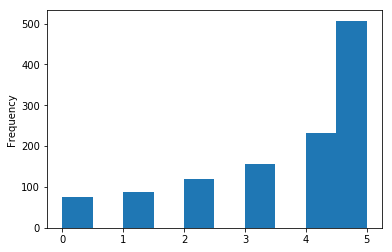

In [40]:
ddict.흑자.plot(kind='hist')

In [71]:
ddict.ROA.isnull().value_counts()

False    1787
True        1
Name: ROA, dtype: int64

In [72]:
ddict.shape

(1788, 12)

In [110]:
ddict.loc[ddict.ROA.isnull(),:]

,종목명,구분,업종,현재가,PER,PBR,배당율,시가총액,부채율,ROA,5ROE,Std,흑자
268600,셀리버리,Q,기타서비스,65300,NaN,13.68,,5036,11.64,NaN,-111.72,15.79,0.0


In [126]:
result.head(10)

,종합순위,종목명,구분,업종,현재가,PER,ROA,PBR,시가총액,부채율,pRank,rRank,PR,흑자,5ROE,Std,배당율,등락
001570,1.0,금양,P,화학,2385,5.13,30.43,1.27,1059,157.72,4.0,12.0,16.0,3.0,10.90,31.11,3.33,0
001070,2.0,대한방직,P,섬유의복,16600,5.52,33.47,0.49,882,51.28,17.0,9.0,26.0,1.0,-2.45,6.30,1.80,0
005870,3.0,휴니드,P,전기전자,9230,6.06,26.29,1.14,1313,108.70,29.0,19.0,48.0,5.0,11.80,8.09,,New
063760,4.0,이엘피,Q,반도체,15100,5.08,17.20,1.06,754,15.92,3.0,47.0,50.0,4.0,32.71,17.31,0.98,New
089230,5.0,THE E&M,Q,인터넷,1145,5.81,17.11,4.16,1061,169.44,23.0,49.0,72.0,2.0,-43.90,78.03,,-2
187870,6.0,디바이스이엔지,Q,반도체,13400,6.62,20.89,1.45,922,22.63,48.0,32.0,80.0,4.0,18.97,5.07,1.36,New
101160,7.0,월덱스,Q,반도체,5850,5.53,15.07,1.36,971,85.59,18.0,71.0,89.0,3.0,4.77,14.66,0.85,-3
090460,7.0,비에이치,Q,IT부품,19650,7.70,29.46,2.65,6354,149.99,76.0,13.0,89.0,4.0,16.50,24.47,,-1
036190,8.0,금화피에스시,Q,건설,34300,5.19,13.61,0.93,2058,18.93,5.0,98.0,103.0,5.0,15.93,2.59,3.79,-3
091810,9.0,티웨이항공,P,운수창고,7810,8.24,25.07,1.62,3664,90.90,90.0,20.0,110.0,2.0,128.25,99.36,,-2


In [148]:
ddict.loc[ddict['5ROE'].isnull(),:]

,종목명,구분,업종,현재가,PER,PBR,배당율,시가총액,부채율,ROA,5ROE,Std,흑자
294870,HDC현대산업개발,P,건설,46200,8.89,1.11,1.08,20431,163.69,5.78,NaN,NaN,NaN
300720,한일시멘트,P,비금속광물,147000,11.42,0.71,3.04,6135,57.56,3.80,NaN,NaN,NaN
298040,효성중공업,P,전기전자,40100,199.13,0.42,,3781,279.40,-0.84,NaN,NaN,NaN
306200,세아제강,P,철강금속,63800,25.90,0.33,2.80,1821,90.46,3.23,NaN,NaN,NaN
298050,효성첨단소재,P,화학,128500,NaN,1.48,,5734,443.91,2.95,NaN,NaN,NaN
298020,효성티앤씨,P,화학,167500,34.02,1.78,0.60,7227,544.66,1.04,NaN,NaN,NaN
298000,효성화학,P,화학,138000,21.90,1.21,0.71,4466,350.17,2.58,NaN,NaN,NaN


In [152]:
ddict.groupby('업종')['5ROE'].mean()

업종
IT부품       -7.508431
건설          2.502449
금속          0.672586
기계         -0.539744
기계·장비       5.508272
기타 제조       1.123750
기타서비스     -14.862857
디지털컨텐츠     -3.197895
반도체         3.145872
방송서비스       8.440000
비금속         5.597500
비금속광물       4.931000
서비스         3.345224
섬유·의류       2.292143
섬유의복       -1.755200
소프트웨어       3.887937
오락·문화      -7.298148
운송          4.525000
운송장비·부품     1.870328
운수장비        0.887778
운수창고       10.990870
유통         -0.850238
음식료·담배      8.500000
음식료품        5.521389
의료·정밀기기    -6.679184
의료정밀       11.223333
의약품         2.830952
인터넷         0.653750
일반전기전자      5.724565
전기가스        5.321111
전기전자       -2.160370
정보기기       -2.813158
제약        -13.803375
종이·목재       6.171111
종이목재       -6.286000
철강금속       -2.430000
출판·매체복제    -4.289444
컴퓨터서비스      2.561429
통신         -3.250000
통신서비스      10.523333
통신장비       -3.014043
화학          5.961698
Name: 5ROE, dtype: float64